In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

In [2]:
integrator = {
    'type': 'direct_reparam',
}

In [3]:
scene = mi.load_file('../scenes/editing-a-scene/cbox.xml')

In [4]:
image_ref = mi.render(scene, spp=1024)

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [5]:
params = mi.traverse(scene)

reflectanceKeys = ['green.reflectance.value', 'red.reflectance.value', 'white.reflectance.value']

# Save the original value
param_refs = dict(zip(reflectanceKeys, [mi.Color3f(params[key]) for key in reflectanceKeys]))

# Initialize the random number generator
numOfChannels = 3
rng = mi.PCG32(size=numOfChannels * len(param_refs))
samples = rng.next_float64()

# Set another color value and update the scene
for i, key in enumerate(reflectanceKeys):
    params[key] = mi.Color3f(
        samples[i*numOfChannels], samples[i*numOfChannels+1], samples[i*numOfChannels+2])
params[reflectanceKeys[2]] = mi.Color3f(1, 0, 0) # set white walls to red

params.update();


In [6]:
initial_light_vertex_positions = dr.unravel(mi.Point3f, params['light.vertex_positions'])

In [7]:
param_refs['light.vertex_positions'] = initial_light_vertex_positions

In [8]:
type(initial_light_vertex_positions)

mitsuba.cuda_ad_rgb.Point3f

In [9]:
# reflactence optimizer
reflectanceOpt = mi.ad.Adam(lr=0.05)
for key in reflectanceKeys:
    reflectanceOpt[key] = params[key]
params.update(reflectanceOpt);

# # translate light position
transformationOpt = mi.ad.Adam(lr=0.05)
transformationOpt['trans'] = mi.Point2f(0, -1)

In [10]:
def apply_transformations(params, transformationOpt):
    if 'trans' not in transformationOpt:
        return
    transformationOpt['trans'] = dr.clamp(transformationOpt['trans'], -1, 0.0)

    trafo = mi.Transform4f.translate([transformationOpt['trans'].x, transformationOpt['trans'].y, 0.0])

    params['light.vertex_positions'] = dr.ravel(trafo @ initial_light_vertex_positions)
    params.update()

In [11]:
# translate light position
apply_transformations(params, transformationOpt)

In [12]:
img_init = mi.render(scene, spp=1024) # seed = 0 missing
mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [13]:
def mse(image):
    return dr.mean(dr.sqr(image - image_ref))

In [14]:
iteration_count = 200
minError = 0.0009

In [15]:
loss_hist = []
err_refs = dict(zip(reflectanceKeys, dr.full(mi.Float,  dr.inf, len(reflectanceKeys))))
err_refs['light.vertex_positions'] = dr.inf

In [16]:
for it in range(iteration_count):

    # check all optimization parameters and if defined threshold is achieved
    # stop optimization for that parameter
    # TODO currently dirty
    shouldStop = True
    for key in err_refs:
        if err_refs[key] < minError:
            if key == 'light.vertex_positions':
                if err_refs[key] < 0.0001:
                    if 'trans' in transformationOpt:
                        transformationOpt.variables.pop('trans')
                        print('Resetted optimization:', key)
            else:
                if key in reflectanceOpt:
                    reflectanceOpt.variables.pop(key)
                    print('Resetted optimization:', key)
            shouldStop = shouldStop & True
        else:
            shouldStop = False

    # stop optimization if all optimization parameters achieved to reach some
    # defined threshold
    if shouldStop:
        break

    # apply mesh transformation
    apply_transformations(params, transformationOpt)

    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, seed=it, spp=16)

    # Evaluate the objective function from the current rendered image
    loss = mse(image)
    # loss = dr.sum(dr.sqr(image - image_ref)) / len(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    reflectanceOpt.step()
    transformationOpt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in reflectanceKeys:
        if key in reflectanceOpt:
            reflectanceOpt[key] = dr.clamp(reflectanceOpt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(reflectanceOpt)

    print(f"Iteration {it:02d}")
    for key in param_refs:
        tmp = params[key]
        if key == 'light.vertex_positions':
            tmp = dr.unravel(type(initial_light_vertex_positions), params['light.vertex_positions'])
        err_ref = dr.sum(dr.sqr(param_refs[key] - tmp))
        err_refs[key] = err_ref[0]
        print(f"\tkey= {key} error= {err_ref[0]:6f}")
    loss_hist.append(loss)
    # print(f"Iteration {it:02d}:  error={loss[0]:6f}", end='\r')
print('\nOptimization complete.')

Iteration 00
	key= green.reflectance.value error= 0.749606
	key= red.reflectance.value error= 0.495694
	key= white.reflectance.value error= 0.936643
	key= light.vertex_positions error= 1.000000
Iteration 01
	key= green.reflectance.value error= 0.661382
	key= red.reflectance.value error= 0.402530
	key= white.reflectance.value error= 0.932730
	key= light.vertex_positions error= 1.002500
Iteration 02
	key= green.reflectance.value error= 0.587695
	key= red.reflectance.value error= 0.321570
	key= white.reflectance.value error= 0.933721
	key= light.vertex_positions error= 1.008927
Iteration 03
	key= green.reflectance.value error= 0.528964
	key= red.reflectance.value error= 0.253697
	key= white.reflectance.value error= 0.939423
	key= light.vertex_positions error= 1.017223
Iteration 04
	key= green.reflectance.value error= 0.485304
	key= red.reflectance.value error= 0.196879
	key= white.reflectance.value error= 0.949477
	key= light.vertex_positions error= 1.024718
Iteration 05
	key= green.refle

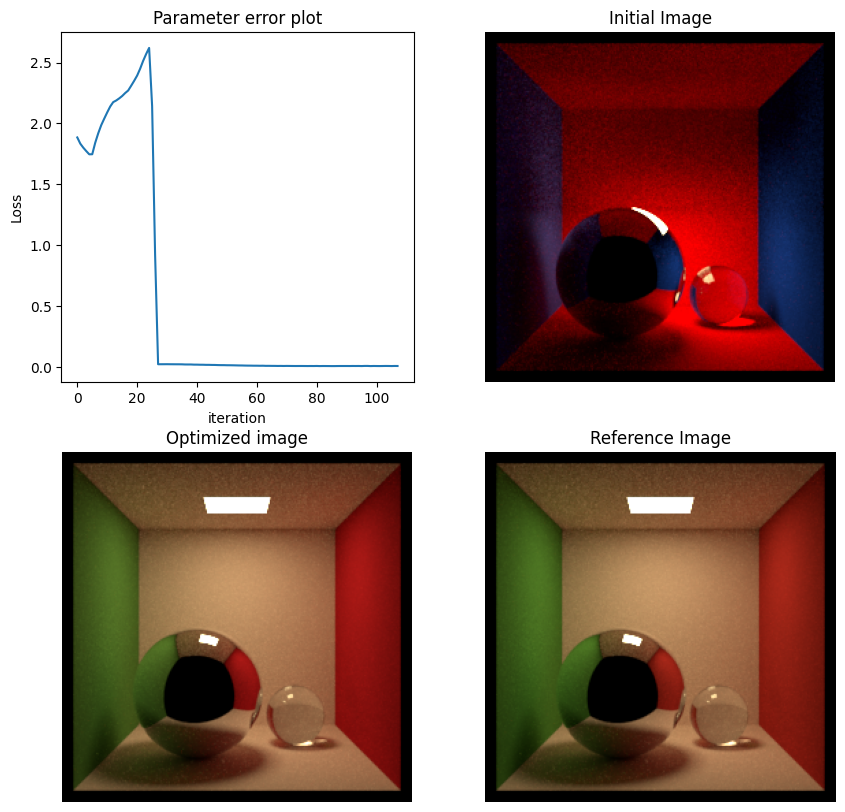

In [19]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(image_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

fig.savefig('optimization-test-figure.png')